In [1]:
# ---- Nested function ---- #
import os
import pandas as pd
import wfdb
import ast
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
from pprint import pprint
from collections import Counter
import math
from copy import deepcopy
import random

# # ---- BWR ---- #
# import bwr
# import emd
import pywt
# ---- Scipy ---- #
from scipy import signal
from scipy.signal import butter, lfilter, freqz, filtfilt
from scipy.fftpack import fft
from scipy.signal import find_peaks
from scipy.interpolate import interp1d


# ---- PyTorch ---- #
import torch
import torchvision
import torch.nn.functional as Func
from torch import nn
from torch import optim
from torch import functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.transforms import ToTensor
from torch.nn.functional import softmax
from torch.nn.parallel import DistributedDataParallel
from pytorchtools import EarlyStopping
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
import torchvision.ops as ops
import tensorboard
from tensorboardX import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau,CosineAnnealingLR,CosineAnnealingWarmRestarts

# ---- Scikit Learn ---- #
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import KFold


# ---- Matplotlib ---- #
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Summary ---- #
import pytorch_model_summary


In [2]:
def load_raw_data(df, sampling_rate, path):
    data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [3]:
sampling_rate = 500

ptb_xl_path = "/data/graduate/ptbxl_103/"

In [4]:
super_class = {}

classes_csv = pd.read_csv(ptb_xl_path+"scp_statements.csv")
classes_csv.rename(columns={"Unnamed: 0":"specific_class"}, inplace=True)
classes_csv["diagnostic_class"] = classes_csv["diagnostic_class"].fillna("OTHERS")

for i in range(len(classes_csv)):
    name = classes_csv.iloc[i].specific_class
    super_c = classes_csv.iloc[i].diagnostic_class
    super_class[name] = super_c

In [5]:
Y = pd.read_csv(ptb_xl_path+"ptbxl_database.csv", index_col="ecg_id")

In [6]:
class PTBXL(Dataset):
    
    def __init__(self, data_root, 
                folds=[1,2,3,4,5,6,7,8,9,10], 
                class_map = {"NORM":0, "MI":1, "STTC":2, "CD":3, "HYP":4},
                sampling_rate = 500,
                verbose=False,
                transform=None
                ):
        
            self.data_root = data_root
            y = pd.read_csv(os.path.join(self.data_root, 'ptbxl_database.csv'), index_col='ecg_id')
            self.folds = folds
            self.class_map = class_map
            self.sampling_rate = sampling_rate
            self.verbose = verbose
            self.transform = transform

            y = y.loc[y.strat_fold.isin(self.folds)]

             # Load scp_statements.csv for diagnostic aggregation
            agg_df = pd.read_csv(os.path.join(data_root, "scp_statements.csv"), index_col=0)
            self.agg_df = agg_df[agg_df.diagnostic == 1]

            # Apply diagnostic superclass
            y.scp_codes = y.scp_codes.apply(lambda x: ast.literal_eval(x))
            y['diagnostic_superclass'] = y.scp_codes.apply(self.aggregate_diagnostic)

            # Convert to Class numbers
            y["class_ids"] = y.diagnostic_superclass.apply(self.map_class_num)

            self.y = y

            if self.verbose:
                print("unique super classes=", self.agg_df.diagnostic_class.unique())
                print("unique folds=",self.y.strat_fold.unique())
                print(self.agg_df)
                print(self.y.scp_codes)
                print("Class labels=", self.y.diagnostic_superclass)
                print("Class ids=", self.y.class_ids)

    def aggregate_diagnostic(self, y_dic):
        tmp = []
        #print(y_dic)
        for key in y_dic.keys():
            if key in self.agg_df.index:
                tmp.append(self.agg_df.loc[key].diagnostic_class)
        #print("temp =",  tmp)
        return list(set(tmp))

    def map_class_num(self, class_labels):
        temp = []
        try:
            for l in class_labels:
                class_id = self.class_map[l]
                temp.append(class_id)
        except:
            print("These labels are wrong:", class_labels)
        return temp

    def read_row_data(self, data_path):
        signal, meta = wfdb.rdsamp(data_path)
        #data = np.array([signal for signal, meta in data])
        if self.verbose:
            print(signal)
            print(meta)
        return np.array(signal), meta
    
    # Powerline Noise Filtering
    def lowpass_filt(self, fs, low, order=5):
        nyq = 0.5 * fs # 250Hz
    #     lowcut = ((2*low)/fs)
        lowcut = low / nyq
        b, a = butter(order, lowcut, btype="low")
        return b, a

    def powerline_Noise_Filtering(self, fs, low, order, data):
        b, a = self.lowpass_filt(fs, low, order)
        filtered_ecg_data = lfilter(b, a, data)
        return filtered_ecg_data

    def bandpass_filt(self, fs, low, high, order=5):
        nyq = 0.5 * fs
        lowcut = low / nyq
        highcut = high / nyq
        b, a = butter(order, [lowcut, highcut], btype="band")
        return b, a
    
    def butter_bandpass(self, fs, low, high ,data , order=5):
        b, a = self.bandpass_filt(fs, low, high, order)
        y = lfilter(b, a, data)
        return y
    
    def wavelet_baseline(self, x):
        level = 8
        wavelet = "sym4"
        coeffs = pywt.wavedec(x, wavelet, level=level)
        threshold=1.2
        coeffs[1:] = (pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:])
        signal = pywt.waverec(coeffs,wavelet)
        return x-signal

    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):

        y_row = self.y.iloc[idx]
        class_ids = y_row.class_ids

        class_encoded = np.zeros(len(self.class_map))
        class_encoded[class_ids] = 1

        if self.verbose:
            print(class_ids)
            print(class_encoded)

        # To get sample rate 100 ECGs
        if self.sampling_rate == 100:
            data_path = os.path.join(self.data_root, y_row.filename_lr)
            ecg, meta = self.read_row_data(data_path)
        # To get sample rate 500 ECGs
        elif self.sampling_rate == 500:
            data_path = os.path.join(self.data_root, y_row.filename_hr)
            ecg, meta = self.read_row_data(data_path)

        else:
            print("Wrong sample rate")
            exit

        # Get transpose
        #print(ecg.shape)
        ecg = ecg.transpose()
        #print(ecg.shape)
#         ecg = torch.from_numpy(ecg).to(torch.float32)
#         class_encoded = torch.from_numpy(class_encoded).to(torch.float32)

        for lead in range(len(ecg)):
            #Powerline Noise Filtering
            ecg[lead] = self.powerline_Noise_Filtering(sampling_rate, 45, 5, ecg[lead])
            # ecg[lead] = self.wavelet_baseline(ecg[lead])
#         print("ecg_shape=", ecg.shape)
        sample = {"ecg":ecg, "class":class_encoded }
        return sample


In [7]:
train_data = PTBXL(ptb_xl_path,folds=[1,2,3,4,5,6,7,8],verbose=False)
valid_data = PTBXL(ptb_xl_path,folds=[9],verbose=False)
test_data = PTBXL(ptb_xl_path,folds=[10],verbose=False)

In [8]:
x_train = []
y_train = []
x_valid = []
y_valid = []
x_test = []
y_test = []
for i, d in enumerate(train_data):
    ecg = d["ecg"]
    labels = d["class"]
    if sum(labels) == 1:
        x_train.append(ecg)
        y_train.append(labels)

for i, d in enumerate(valid_data):
    ecg = d["ecg"]
    labels = d["class"]
    if sum(labels) == 1:
        x_valid.append(ecg)
        y_valid.append(labels)
    
for i, d in enumerate(test_data):
    ecg = d["ecg"]
    labels = d["class"]
    if sum(labels) == 1:
        x_test.append(ecg)
        y_test.append(labels)

# Fit Transform
# lead_Scaler = [StandardScaler() for _ in range(12)]
# stdScaler = StandardScaler() 
stdScaler= MinMaxScaler()
for i, xt in enumerate(x_train):
    r_xt = xt.T
    r_xt = stdScaler.fit_transform(r_xt)
    # r_xt = lead_Scaler[j].fit_transform(r_xt)
    r_xt = r_xt.T
    x_train[i] = r_xt

for i, xt in enumerate(x_test):
    r_xt = xt.T
    r_xt = stdScaler.transform(r_xt)
    # r_xt = lead_Scaler[j].fit_transform(r_xt)
    r_xt = r_xt.T
    x_test[i] = r_xt
for i, xt in enumerate(x_valid):
    r_xt = xt.T
    r_xt = stdScaler.transform(r_xt)
    # r_xt = lead_Scaler[j].fit_transform(r_xt)
    r_xt = r_xt.T
    x_valid[i] = r_xt


[1. 0. 0. 0. 0.]


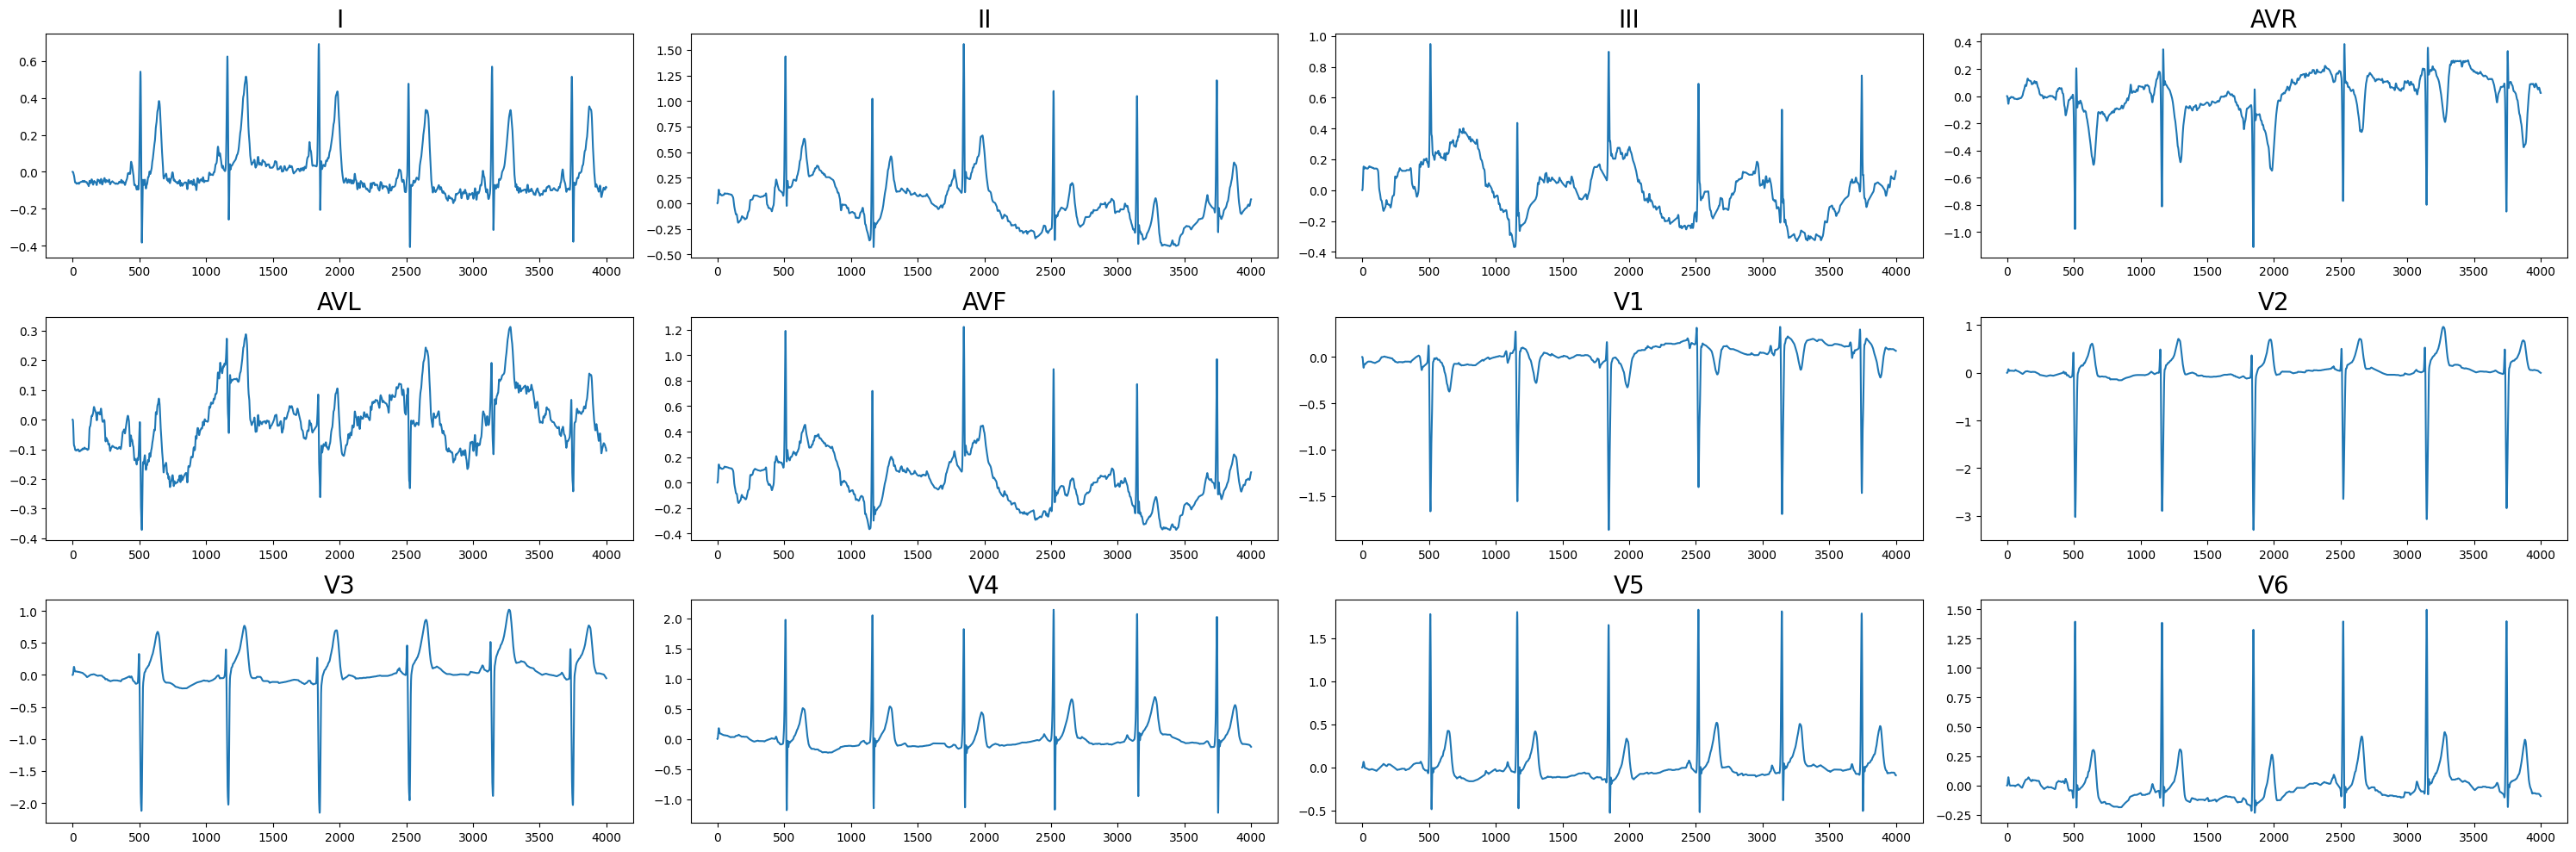

In [9]:
fig = plt.figure(figsize=(30,10))
leadNames = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
print(y_train[1])
for i,lead in enumerate(leadNames):
    ax1 = fig.add_subplot(3,4,i+1)
    ax1.set_title(leadNames[i], fontsize=20)
    ax1.plot(x_train[1][i][0:4000])
fig.tight_layout()

In [10]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [11]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((12957, 12, 5000),
 (12957, 5),
 (1637, 12, 5000),
 (1637, 5),
 (1650, 12, 5000),
 (1650, 5))

In [12]:
# ---- ViT Model ---- #
import vit_model

In [13]:
def get_DataLoader(x, y, batch, num_workers, shuffle=False):
    x_tensor = torch.FloatTensor(x)
    y_tensor = torch.FloatTensor(y)
    dataset = TensorDataset(x_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=shuffle)
    return dataloader

In [14]:
class AsymmetricLoss(nn.Module):
    # 4,1, 1e-8
    def __init__(self, gamma_neg=4, gamma_pos=2, clip=0.05, eps=1e-5, disable_torch_grad_focal_loss=True):
        super(AsymmetricLoss, self).__init__()
 
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps
 
    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """
 
        # Calculating Probabilities
        x_sigmoid = torch.sigmoid(x)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid
 
        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)
 
        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg
 
        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w
 
        return -loss.sum()

In [15]:
class ViTEmbeddings(nn.Module):
    def __init__(self, in_channel, emb_size, patch_size, dropout=0.0):
        super().__init__()
        
        self.patch_size= patch_size
        self.emb_size= emb_size
        
        self.patch_embeddings = nn.Sequential(
            nn.Conv1d(in_channel, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange("b e (p) -> b (p) e")
        )
        self.dropout = nn.Dropout(dropout)
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.emb_size))
        num_patches = 5000//patch_size
        self.positions = nn.Parameter(torch.randn(1, num_patches +1, self.emb_size)) ## Num Patches....어케하지
    
    def forward(self, x):
        input_shape = x.shape # B C L
        embeddings = self.patch_embeddings(x)
        cls_token = repeat(self.cls_token, "() n e -> b n e", b=input_shape[0])
        x = torch.cat([cls_token, embeddings], dim=1)

        x += self.positions
        x = self.dropout(x)
        return x


class MLP(nn.Module):
    def __init__(self, emb_size: int = 768, expansion: int = 4, dropout=0.2, mlp_dim=256):
        super().__init__()
        self.mlps = nn.Sequential(
            nn.Linear(emb_size, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, emb_size),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        x = self.mlps(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, emb_size: int=768, num_heads: int=6,f_expansion: int=4, f_dropout=0.35, dropout=0.2, sd_survive=0.0,**kwargs):
        super().__init__()
        self.attn = nn.MultiheadAttention(emb_size, num_heads, dropout, bias=False, batch_first=True)
        self.lnorm_b = nn.LayerNorm(emb_size)
        self.lnorm_a = nn.LayerNorm(emb_size)
        self.dropout = nn.Dropout(0.2)
        self.mlp = MLP(emb_size, expansion=f_expansion, dropout=f_dropout, mlp_dim=256)
        self.sd_survive=sd_survive
        self.actv1 = nn.GELU()
        self.actv2 = nn.GELU()
    
        self.stochasticLayer = ops.StochasticDepth(sd_survive, "row")
        
    def forward(self, x):
        x_norm = self.lnorm_b(x)
        x_norm, _ = self.attn(x_norm, x_norm, x_norm, average_attn_weights=False)
        # x_norm = self.dropout(x_norm)
        x_norm = self.stochasticLayer(x_norm)
        x = torch.add(x_norm, x)
        x2_norm = self.lnorm_a(x)
        x2_norm = self.mlp(x2_norm)
        x2_norm = self.stochasticLayer(x2_norm)
        # x2_norm = self.dropout(x2_norm)
        x2 = torch.add(x2_norm, x)
        return x2
    
    def get_attention_scores(self, inputs):
        x = self.lnorm_b(inputs)
        output, weight = self.attn(x, x, x, average_attn_weights=False)
        print(output.shape, weight.shape)
        return weight

class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int=768, n_classes: int=5):
        super().__init__(
            # Reduce("b n e -> b e", reduction="mean"),
            nn.LayerNorm(emb_size),
            # nn.GELU(),
            nn.Linear(emb_size, n_classes)
        )

class ViT(nn.Module):
    def __init__(self, in_channel: int= 12, patch_size: int= 20, emb_size: int= 768, num_heads: int= 6, n_classes: int= 5, depth: int= 6, mlp_dim: int=256):
        super().__init__()
        self.in_channel = in_channel
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.n_classes = n_classes
        self.depth = depth
        self.mlp_dim = 256
        self.sd_survive = np.linspace(0, 0.1, depth)
        self.Blocks = nn.ModuleList([
            EncoderBlock(emb_size=self.emb_size, mlp_dim=self.mlp_dim, sd_survive=self.sd_survive[i]) for i in range(depth)
        ])
        self.Embeddings = ViTEmbeddings(in_channel, emb_size, patch_size)
        self.ClassificationHead = ClassificationHead(emb_size, n_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.Embeddings(x)
        for block in self.Blocks:
            x = block(x)
        x = x[:,0]
        result = self.ClassificationHead(x)
        return result
    
    def get_last_selfattention(self, inputs):
        x = self.Embeddings(inputs)
        for block in self.Blocks[:-1]:
            x = block(x)
        return self.Blocks[-1].get_attention_scores(x)

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
# Evaluate
from sklearn.metrics import multilabel_confusion_matrix, classification_report

label_names = ['NORM', 'MI', 'STTC', 'HYP', 'CD']

logits_list = []
gt_list = []
def Evaluate(model, test_loader):
    global gt_list, logits_list
    model.eval()
    test_bar = tqdm(test_loader)
    total = len(test_loader.dataset)
    
    for step, (x,y) in enumerate(test_bar):
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            logits = model(x).cpu().detach().numpy()
            # logits = logits > 0.5
            logits = logits.astype(int)
            for l in logits:
                logits_list.append(l)
            y = y.cpu().detach().numpy()
            for gt in y:
                gt_list.append(gt.astype(int))
            
    print(classification_report(gt_list, logits_list, target_names=label_names))

In [18]:
epochs = 50

early_stopping = EarlyStopping(patience=10, verbose=False)

loss_list=[]
val_loss_list = []

best_models = []


idx = 0

# for neg,pos,eps in [(4,2,1e-5),(3,2,1e-5),(2,2,1e-5),(3,1,1e-5)]:
# loss_asl = AsymmetricLoss()

criterion = nn.CrossEntropyLoss().to(device)
for batch in [16]:
    # writer = SummaryWriter("runs/vit/1122")
    
    train_loader = get_DataLoader(x_train, y_train, batch=batch, num_workers=4, shuffle=True)
    valid_loader = get_DataLoader(x_valid, y_valid, batch=32, num_workers=1, shuffle=True)
    test_loader = get_DataLoader(x_test, y_test, batch=32, num_workers=1, shuffle=True)
    
    for lr in [1e-4,1e-5,5e-4,5e-5]:
        model = ViT()
        model.to(device)
        best_loss = np.inf
        
        # optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=0.01) 
        optimizer = optim.AdamW(model.parameters(), lr=lr)
                               
        # schedular = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=4, verbose=True, eps=1e-8)
        schedular = CosineAnnealingLR(optimizer, T_max = 30, eta_min = 0,verbose=True)
        # schedular = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0,verbose=True)
        print(f"===============================================================================================")
        print(f"======================= Batch {batch} | Learning Rate {lr} | MIDX {idx} =======================")
        print(f"===============================================================================================")
        
        for ep in range(epochs):
            train_bar = tqdm(train_loader)
            train_total_loss = 0
            for step, (x,y) in enumerate(train_bar):
                model.train()
                x, y = x.to(device), y.to(device)
                
                
                optimizer.zero_grad()
                logits = model(x)
                loss = criterion(logits, y)
                # loss = loss_asl(logits, y)
                # print(loss.shape) # Batch, class
                
                loss.backward()
                optimizer.step()
                train_total_loss += loss
                train_bar.desc = "Train Epoch[{}/{}] loss: {:.3f}".format(ep+1, epochs, loss.item())
                # writer.add_scalar(f"Training loss_Batch_{batch}_{lr}", loss, ep * len(train_loader) + step)
        
            
            with torch.no_grad():
                model.eval()
                val_loss = 0.0
                val_bar = tqdm(valid_loader)
                for v_step, (val_x, val_y) in enumerate(val_bar):
                    val_x, val_y = val_x.to(device), val_y.to(device)
                    val_logits = model(val_x)
                    # loss_v = loss_asl(val_logits, val_y)
                    loss_v = criterion(val_logits, val_y)
                    val_loss_list.append(loss_v.item())
                    val_loss += loss_v.item()
                    # writer.add_scalar(f"Validation loss_Batch_{batch}_{lr}", loss_v, ep * len(valid_loader) + step)
                print("Training loss :",(train_total_loss/len(train_loader)).item())
                print("Validation loss :",val_loss/len(valid_loader))
        
                if best_loss > val_loss:
                    print("Validation Loss Decrease.. Best Model, Best Loss update")
                    best_loss = val_loss
                    torch.save(model.state_dict(), f"models/1127/{batch}_{ep}_Saved_ViT_model_{round((val_loss/len(valid_loader))*100,2)}_{lr}_bce.pth")
            schedular.step()
            # early_stopping(loss., model)
            # if early_stopping.early_stop:
            #     break
        best_models.append(model)

        idx+=1

        torch.save(model.state_dict(), f"models/1127/Saved_ViT_model_FinalEpoch_{batch}_{lr}_{epochs}_bce.pth")
        
                
       
    
# print("Evaluate")
# Evaluate(model,test_loader)

Adjusting learning rate of group 0 to 1.0000e-04.
======================= Batch 16 | Learning Rate 0.0001 | MIDX 0 =======================


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 31.62it/s]


Training loss : 1.0768791437149048
Validation loss : 0.8983463175021685
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 9.9726e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 31.30it/s]


Training loss : 0.8480089902877808
Validation loss : 0.8000834584236145
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 9.8907e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 30.62it/s]


Training loss : 0.759800374507904
Validation loss : 0.8533755500729268
Adjusting learning rate of group 0 to 9.7553e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 30.84it/s]


Training loss : 0.6948696374893188
Validation loss : 0.774809870009239
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 9.5677e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.20it/s]


Training loss : 0.6300702691078186
Validation loss : 0.8022991633759096
Adjusting learning rate of group 0 to 9.3301e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.64it/s]


Training loss : 0.5812532305717468
Validation loss : 0.8398807770930804
Adjusting learning rate of group 0 to 9.0451e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.15it/s]


Training loss : 0.5347211360931396
Validation loss : 0.80402344923753
Adjusting learning rate of group 0 to 8.7157e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.41it/s]


Training loss : 0.48006612062454224
Validation loss : 0.9147795633627818
Adjusting learning rate of group 0 to 8.3457e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.73it/s]


Training loss : 0.42383691668510437
Validation loss : 0.9414426982402802
Adjusting learning rate of group 0 to 7.9389e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.09it/s]


Training loss : 0.37014254927635193
Validation loss : 0.975858808710025
Adjusting learning rate of group 0 to 7.5000e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 26.08it/s]


Training loss : 0.3306441009044647
Validation loss : 0.9632381682212536
Adjusting learning rate of group 0 to 7.0337e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.24it/s]


Training loss : 0.2843778133392334
Validation loss : 1.1012592756977448
Adjusting learning rate of group 0 to 6.5451e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.65it/s]


Training loss : 0.2273288369178772
Validation loss : 1.1513678139218917
Adjusting learning rate of group 0 to 6.0396e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.53it/s]


Training loss : 0.18913443386554718
Validation loss : 1.266466425015376
Adjusting learning rate of group 0 to 5.5226e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.92it/s]


Training loss : 0.16432078182697296
Validation loss : 1.2668752200328386
Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 30.71it/s]


Training loss : 0.12874870002269745
Validation loss : 1.4257026280348117
Adjusting learning rate of group 0 to 4.4774e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.50it/s]


Training loss : 0.10777085274457932
Validation loss : 1.5166711658239365
Adjusting learning rate of group 0 to 3.9604e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.67it/s]


Training loss : 0.09149837493896484
Validation loss : 1.5331964733508916
Adjusting learning rate of group 0 to 3.4549e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.08it/s]


Training loss : 0.07222665101289749
Validation loss : 1.632164945969215
Adjusting learning rate of group 0 to 2.9663e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 30.89it/s]


Training loss : 0.05312968045473099
Validation loss : 1.8261862844228745
Adjusting learning rate of group 0 to 2.5000e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.14it/s]


Training loss : 0.047638073563575745
Validation loss : 1.824112933415633
Adjusting learning rate of group 0 to 2.0611e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 30.53it/s]


Training loss : 0.037194471806287766
Validation loss : 1.8134577079461172
Adjusting learning rate of group 0 to 1.6543e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.98it/s]


Training loss : 0.032575592398643494
Validation loss : 1.9381831196638255
Adjusting learning rate of group 0 to 1.2843e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.55it/s]


Training loss : 0.024288786575198174
Validation loss : 2.007154156955389
Adjusting learning rate of group 0 to 9.5492e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.61it/s]


Training loss : 0.02519255131483078
Validation loss : 1.9445696721522836
Adjusting learning rate of group 0 to 6.6987e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 30.84it/s]


Training loss : 0.022958826273679733
Validation loss : 1.9724517980447183
Adjusting learning rate of group 0 to 4.3227e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.27it/s]


Training loss : 0.017896335572004318
Validation loss : 2.0694898940049686
Adjusting learning rate of group 0 to 2.4472e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.55it/s]


Training loss : 0.017731711268424988
Validation loss : 2.0249621959832997
Adjusting learning rate of group 0 to 1.0926e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.35it/s]


Training loss : 0.01290881633758545
Validation loss : 2.008671099749895
Adjusting learning rate of group 0 to 2.7391e-07.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 22.19it/s]


Training loss : 0.01551278866827488
Validation loss : 2.071931390808179
Adjusting learning rate of group 0 to 0.0000e+00.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.20it/s]


Training loss : 0.01811503805220127
Validation loss : 2.0545116117080817
Adjusting learning rate of group 0 to 2.7391e-07.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.91it/s]


Training loss : 0.013965078629553318
Validation loss : 2.037282183766365
Adjusting learning rate of group 0 to 1.0926e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.65it/s]


Training loss : 0.013182895258069038
Validation loss : 2.0500389773112078
Adjusting learning rate of group 0 to 2.4472e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.75it/s]


Training loss : 0.01449207216501236
Validation loss : 2.088482527778699
Adjusting learning rate of group 0 to 4.3227e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.31it/s]


Training loss : 0.013992044143378735
Validation loss : 2.116391298862604
Adjusting learning rate of group 0 to 6.6987e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.15it/s]


Training loss : 0.014569003134965897
Validation loss : 2.1719374736914268
Adjusting learning rate of group 0 to 9.5492e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.44it/s]


Training loss : 0.01837141439318657
Validation loss : 2.0904573786717195
Adjusting learning rate of group 0 to 1.2843e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.37it/s]


Training loss : 0.017741579562425613
Validation loss : 2.117778562582456
Adjusting learning rate of group 0 to 1.6543e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.21it/s]


Training loss : 0.023793252184987068
Validation loss : 2.109747357093371
Adjusting learning rate of group 0 to 2.0611e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.35it/s]


Training loss : 0.027488648891448975
Validation loss : 2.0982394952040453
Adjusting learning rate of group 0 to 2.5000e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.09it/s]


Training loss : 0.033641766756772995
Validation loss : 1.9456684050651698
Adjusting learning rate of group 0 to 2.9663e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.25it/s]


Training loss : 0.042679231613874435
Validation loss : 1.9113906891300128
Adjusting learning rate of group 0 to 3.4549e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.09it/s]


Training loss : 0.04885637015104294
Validation loss : 1.8693154729329622
Adjusting learning rate of group 0 to 3.9604e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.85it/s]


Training loss : 0.049483686685562134
Validation loss : 2.0473742505105643
Adjusting learning rate of group 0 to 4.4774e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.64it/s]


Training loss : 0.06309237331151962
Validation loss : 1.866020254790783
Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 30.86it/s]


Training loss : 0.07521051168441772
Validation loss : 1.892362884604014
Adjusting learning rate of group 0 to 5.5226e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.99it/s]


Training loss : 0.07848117500543594
Validation loss : 1.6237382590770721
Adjusting learning rate of group 0 to 6.0396e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 30.59it/s]


Training loss : 0.0914541557431221
Validation loss : 1.525340777177077
Adjusting learning rate of group 0 to 6.5451e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.36it/s]


Training loss : 0.0915832445025444
Validation loss : 1.5292081735455072
Adjusting learning rate of group 0 to 7.0337e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.62it/s]


Training loss : 0.09419501572847366
Validation loss : 1.6613742995720644
Adjusting learning rate of group 0 to 7.5000e-05.
Adjusting learning rate of group 0 to 1.0000e-05.
======================= Batch 16 | Learning Rate 1e-05 | MIDX 1 =======================


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.50it/s]


Training loss : 1.2067850828170776
Validation loss : 1.1671014405213869
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 9.9726e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.51it/s]


Training loss : 1.1141196489334106
Validation loss : 1.0448379459289403
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 9.8907e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.28it/s]


Training loss : 1.013038158416748
Validation loss : 0.986717586333935
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 9.7553e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.39it/s]


Training loss : 0.9351083040237427
Validation loss : 0.9381406072240609
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 9.5677e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.82it/s]


Training loss : 0.8803983926773071
Validation loss : 0.9229768354159135
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 9.3301e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.02it/s]


Training loss : 0.8371661305427551
Validation loss : 0.9482464985205576
Adjusting learning rate of group 0 to 9.0451e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.19it/s]


Training loss : 0.8061339855194092
Validation loss : 0.881270516377229
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 8.7157e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.55it/s]


Training loss : 0.772636890411377
Validation loss : 0.8758704564892329
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 8.3457e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.37it/s]


Training loss : 0.7422504425048828
Validation loss : 0.8735287900154407
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 7.9389e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.86it/s]


Training loss : 0.7142382264137268
Validation loss : 0.9154202651519042
Adjusting learning rate of group 0 to 7.5000e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.88it/s]


Training loss : 0.6963226795196533
Validation loss : 0.8801994896852053
Adjusting learning rate of group 0 to 7.0337e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.92it/s]


Training loss : 0.671118974685669
Validation loss : 0.8734758444703542
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 6.5451e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.78it/s]


Training loss : 0.659054696559906
Validation loss : 0.8650493547320366
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 6.0396e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.47it/s]


Training loss : 0.6450014710426331
Validation loss : 0.8734713586477133
Adjusting learning rate of group 0 to 5.5226e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.29it/s]


Training loss : 0.6240572333335876
Validation loss : 0.8622890452925975
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 5.0000e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.88it/s]


Training loss : 0.6142082810401917
Validation loss : 0.8904848264960142
Adjusting learning rate of group 0 to 4.4774e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.29it/s]


Training loss : 0.5996208786964417
Validation loss : 0.886010141326831
Adjusting learning rate of group 0 to 3.9604e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.03it/s]


Training loss : 0.5889958739280701
Validation loss : 0.8701562849948039
Adjusting learning rate of group 0 to 3.4549e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.23it/s]


Training loss : 0.5773919224739075
Validation loss : 0.8807203709506072
Adjusting learning rate of group 0 to 2.9663e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.86it/s]


Training loss : 0.5630286335945129
Validation loss : 0.9002297113721187
Adjusting learning rate of group 0 to 2.5000e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.72it/s]


Training loss : 0.5624959468841553
Validation loss : 0.9034260660409927
Adjusting learning rate of group 0 to 2.0611e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.57it/s]


Training loss : 0.5551097393035889
Validation loss : 0.931888059927867
Adjusting learning rate of group 0 to 1.6543e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.98it/s]


Training loss : 0.5451036691665649
Validation loss : 0.9049872859166219
Adjusting learning rate of group 0 to 1.2843e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.66it/s]


Training loss : 0.5356370806694031
Validation loss : 0.9186871091906841
Adjusting learning rate of group 0 to 9.5492e-07.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.31it/s]


Training loss : 0.5326100587844849
Validation loss : 0.9416908151828326
Adjusting learning rate of group 0 to 6.6987e-07.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.03it/s]


Training loss : 0.5370563268661499
Validation loss : 0.917976261044924
Adjusting learning rate of group 0 to 4.3227e-07.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.80it/s]


Training loss : 0.5291232466697693
Validation loss : 0.9510793496782963
Adjusting learning rate of group 0 to 2.4472e-07.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.68it/s]


Training loss : 0.5282474160194397
Validation loss : 0.9281066828049146
Adjusting learning rate of group 0 to 1.0926e-07.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.41it/s]


Training loss : 0.5300168395042419
Validation loss : 0.9288731744656196
Adjusting learning rate of group 0 to 2.7391e-08.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.42it/s]


Training loss : 0.5216806530952454
Validation loss : 0.9353198626866708
Adjusting learning rate of group 0 to 0.0000e+00.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.11it/s]


Training loss : 0.522619366645813
Validation loss : 0.9507645483200367
Adjusting learning rate of group 0 to 2.7391e-08.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.16it/s]


Training loss : 0.525451123714447
Validation loss : 0.9293678950231808
Adjusting learning rate of group 0 to 1.0926e-07.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.30it/s]


Training loss : 0.5213502049446106
Validation loss : 0.9235818411868352
Adjusting learning rate of group 0 to 2.4472e-07.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.07it/s]


Training loss : 0.5261833667755127
Validation loss : 0.9259624355114423
Adjusting learning rate of group 0 to 4.3227e-07.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.42it/s]


Training loss : 0.523124635219574
Validation loss : 0.9295286673765916
Adjusting learning rate of group 0 to 6.6987e-07.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.76it/s]


Training loss : 0.524276852607727
Validation loss : 0.9436743505872213
Adjusting learning rate of group 0 to 9.5492e-07.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.91it/s]


Training loss : 0.5216420888900757
Validation loss : 0.9399029389023781
Adjusting learning rate of group 0 to 1.2843e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.99it/s]


Training loss : 0.5247303247451782
Validation loss : 0.9382754654551928
Adjusting learning rate of group 0 to 1.6543e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.74it/s]


Training loss : 0.5275331735610962
Validation loss : 0.9540927163683451
Adjusting learning rate of group 0 to 2.0611e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.45it/s]


Training loss : 0.5220198035240173
Validation loss : 0.9411509650257918
Adjusting learning rate of group 0 to 2.5000e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.98it/s]


Training loss : 0.5202449560165405
Validation loss : 0.9354916885495186
Adjusting learning rate of group 0 to 2.9663e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 31.06it/s]


Training loss : 0.5130971074104309
Validation loss : 0.9379016602268586
Adjusting learning rate of group 0 to 3.4549e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.03it/s]


Training loss : 0.5169948935508728
Validation loss : 0.9495873348071024
Adjusting learning rate of group 0 to 3.9604e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.89it/s]


Training loss : 0.5060935616493225
Validation loss : 0.9684141212357924
Adjusting learning rate of group 0 to 4.4774e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.96it/s]


Training loss : 0.4980425238609314
Validation loss : 0.9909602352059804
Adjusting learning rate of group 0 to 5.0000e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.77it/s]


Training loss : 0.502275824546814
Validation loss : 1.0266701922966883
Adjusting learning rate of group 0 to 5.5226e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.89it/s]


Training loss : 0.4893377721309662
Validation loss : 0.999365855868046
Adjusting learning rate of group 0 to 6.0396e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.34it/s]


Training loss : 0.4901149570941925
Validation loss : 0.9803302568884996
Adjusting learning rate of group 0 to 6.5451e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.15it/s]


Training loss : 0.4774874746799469
Validation loss : 1.0299473244410295
Adjusting learning rate of group 0 to 7.0337e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.68it/s]


Training loss : 0.4729020595550537
Validation loss : 1.0583592091615384
Adjusting learning rate of group 0 to 7.5000e-06.
Adjusting learning rate of group 0 to 5.0000e-04.
======================= Batch 16 | Learning Rate 0.0005 | MIDX 2 =======================


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.25it/s]


Training loss : 1.2525644302368164
Validation loss : 1.249796436383174
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 4.9863e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.02it/s]


Training loss : 1.2595579624176025
Validation loss : 1.2865384679574232
Adjusting learning rate of group 0 to 4.9454e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.59it/s]


Training loss : 1.2583565711975098
Validation loss : 1.2252763188802278
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 4.8776e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.92it/s]


Training loss : 1.2582980394363403
Validation loss : 1.2808858018655043
Adjusting learning rate of group 0 to 4.7839e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 22.29it/s]


Training loss : 1.263598918914795
Validation loss : 1.295248494698451
Adjusting learning rate of group 0 to 4.6651e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.70it/s]


Training loss : 1.2494410276412964
Validation loss : 1.2521670735799348
Adjusting learning rate of group 0 to 4.5225e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.48it/s]


Training loss : 1.2382643222808838
Validation loss : 1.2340266142900174
Adjusting learning rate of group 0 to 4.3579e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.22it/s]


Training loss : 1.2414520978927612
Validation loss : 1.2369293593443358
Adjusting learning rate of group 0 to 4.1728e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.81it/s]


Training loss : 1.2395575046539307
Validation loss : 1.2467057957099035
Adjusting learning rate of group 0 to 3.9695e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.02it/s]


Training loss : 1.2397135496139526
Validation loss : 1.2262103041777244
Adjusting learning rate of group 0 to 3.7500e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.66it/s]


Training loss : 1.233223557472229
Validation loss : 1.2164306182127733
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 3.5168e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.26it/s]


Training loss : 1.2272834777832031
Validation loss : 1.2169991697256382
Adjusting learning rate of group 0 to 3.2725e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.09it/s]


Training loss : 1.2177306413650513
Validation loss : 1.228180971283179
Adjusting learning rate of group 0 to 3.0198e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.89it/s]


Training loss : 1.2093513011932373
Validation loss : 1.2183705155666058
Adjusting learning rate of group 0 to 2.7613e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 22.83it/s]


Training loss : 1.2102742195129395
Validation loss : 1.267638921737671
Adjusting learning rate of group 0 to 2.5000e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 22.63it/s]


Training loss : 1.225099802017212
Validation loss : 1.2291121689172892
Adjusting learning rate of group 0 to 2.2387e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.89it/s]


Training loss : 1.2196340560913086
Validation loss : 1.2356694913827455
Adjusting learning rate of group 0 to 1.9802e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.99it/s]


Training loss : 1.2173510789871216
Validation loss : 1.226144165946887
Adjusting learning rate of group 0 to 1.7275e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.59it/s]


Training loss : 1.2199265956878662
Validation loss : 1.2239507459677184
Adjusting learning rate of group 0 to 1.4832e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.84it/s]


Training loss : 1.219685673713684
Validation loss : 1.2297736738736813
Adjusting learning rate of group 0 to 1.2500e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.92it/s]


Training loss : 1.2156037092208862
Validation loss : 1.221878468990326
Adjusting learning rate of group 0 to 1.0305e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.01it/s]


Training loss : 1.2171930074691772
Validation loss : 1.224836365534709
Adjusting learning rate of group 0 to 8.2717e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.24it/s]


Training loss : 1.216904640197754
Validation loss : 1.2267728115503604
Adjusting learning rate of group 0 to 6.4214e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.52it/s]


Training loss : 1.2176940441131592
Validation loss : 1.2196185978559346
Adjusting learning rate of group 0 to 4.7746e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.59it/s]


Training loss : 1.214313268661499
Validation loss : 1.227653083892969
Adjusting learning rate of group 0 to 3.3494e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 30.82it/s]


Training loss : 1.2116042375564575
Validation loss : 1.222843980559936
Adjusting learning rate of group 0 to 2.1614e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.98it/s]


Training loss : 1.2147963047027588
Validation loss : 1.2357325714368086
Adjusting learning rate of group 0 to 1.2236e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 22.01it/s]


Training loss : 1.2153193950653076
Validation loss : 1.2310440746637492
Adjusting learning rate of group 0 to 5.4631e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 22.82it/s]


Training loss : 1.2137951850891113
Validation loss : 1.2247411883794344
Adjusting learning rate of group 0 to 1.3695e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.17it/s]


Training loss : 1.211491346359253
Validation loss : 1.2235824649150555
Adjusting learning rate of group 0 to 0.0000e+00.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.47it/s]


Training loss : 1.2160093784332275
Validation loss : 1.2282366225352654
Adjusting learning rate of group 0 to 1.3695e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.47it/s]


Training loss : 1.215338945388794
Validation loss : 1.226114815244308
Adjusting learning rate of group 0 to 5.4631e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.67it/s]


Training loss : 1.2144184112548828
Validation loss : 1.230631125661043
Adjusting learning rate of group 0 to 1.2236e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.80it/s]


Training loss : 1.2171626091003418
Validation loss : 1.2450642459667647
Adjusting learning rate of group 0 to 2.1614e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.62it/s]


Training loss : 1.213323712348938
Validation loss : 1.2165673833626967
Adjusting learning rate of group 0 to 3.3494e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.30it/s]


Training loss : 1.2153691053390503
Validation loss : 1.2110799642709584
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 4.7746e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.70it/s]


Training loss : 1.2167719602584839
Validation loss : 1.222149866131636
Adjusting learning rate of group 0 to 6.4214e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.44it/s]


Training loss : 1.2161316871643066
Validation loss : 1.2199423702863545
Adjusting learning rate of group 0 to 8.2717e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.02it/s]


Training loss : 1.2170805931091309
Validation loss : 1.2365761410731535
Adjusting learning rate of group 0 to 1.0305e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 22.77it/s]


Training loss : 1.2226194143295288
Validation loss : 1.227960799749081
Adjusting learning rate of group 0 to 1.2500e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.51it/s]


Training loss : 1.224454641342163
Validation loss : 1.2258339810829897
Adjusting learning rate of group 0 to 1.4832e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.75it/s]


Training loss : 1.2264316082000732
Validation loss : 1.2249615903084095
Adjusting learning rate of group 0 to 1.7275e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.72it/s]


Training loss : 1.2291613817214966
Validation loss : 1.2225376012233586
Adjusting learning rate of group 0 to 1.9802e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.12it/s]


Training loss : 1.2310274839401245
Validation loss : 1.2255462339291205
Adjusting learning rate of group 0 to 2.2387e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.10it/s]


Training loss : 1.2316339015960693
Validation loss : 1.257224439428403
Adjusting learning rate of group 0 to 2.5000e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.56it/s]


Training loss : 1.2290033102035522
Validation loss : 1.211836270414866
Adjusting learning rate of group 0 to 2.7613e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.81it/s]


Training loss : 1.2268496751785278
Validation loss : 1.2284987694942033
Adjusting learning rate of group 0 to 3.0198e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 22.77it/s]


Training loss : 1.2306617498397827
Validation loss : 1.2362385140015528
Adjusting learning rate of group 0 to 3.2725e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 22.67it/s]


Training loss : 1.23124098777771
Validation loss : 1.2325743975547643
Adjusting learning rate of group 0 to 3.5168e-04.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.27it/s]


Training loss : 1.2286744117736816
Validation loss : 1.2187340660737112
Adjusting learning rate of group 0 to 3.7500e-04.
Adjusting learning rate of group 0 to 5.0000e-05.
======================= Batch 16 | Learning Rate 5e-05 | MIDX 3 =======================


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.49it/s]


Training loss : 1.1028341054916382
Validation loss : 0.9657107156056625
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 4.9863e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.69it/s]


Training loss : 0.8722637891769409
Validation loss : 0.8421288946500192
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 4.9454e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.52it/s]


Training loss : 0.7609320282936096
Validation loss : 0.8556315348698542
Adjusting learning rate of group 0 to 4.8776e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.87it/s]


Training loss : 0.6973443031311035
Validation loss : 0.7849979773163795
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 4.7839e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.17it/s]


Training loss : 0.6441242098808289
Validation loss : 0.7758946779828805
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 4.6651e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.26it/s]


Training loss : 0.5964440107345581
Validation loss : 0.8255113082436415
Adjusting learning rate of group 0 to 4.5225e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.42it/s]


Training loss : 0.553901731967926
Validation loss : 0.848408566071437
Adjusting learning rate of group 0 to 4.3579e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 22.94it/s]


Training loss : 0.5032054781913757
Validation loss : 0.8692679462524561
Adjusting learning rate of group 0 to 4.1728e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.69it/s]


Training loss : 0.4565385580062866
Validation loss : 0.8661521684664947
Adjusting learning rate of group 0 to 3.9695e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.69it/s]


Training loss : 0.39953333139419556
Validation loss : 0.9377362808355918
Adjusting learning rate of group 0 to 3.7500e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.25it/s]


Training loss : 0.35039693117141724
Validation loss : 0.9582955685372536
Adjusting learning rate of group 0 to 3.5168e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.32it/s]


Training loss : 0.30666276812553406
Validation loss : 1.0407567964150355
Adjusting learning rate of group 0 to 3.2725e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.11it/s]


Training loss : 0.2559202015399933
Validation loss : 1.1270827014858906
Adjusting learning rate of group 0 to 3.0198e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.35it/s]


Training loss : 0.22140371799468994
Validation loss : 1.181283726142003
Adjusting learning rate of group 0 to 2.7613e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.82it/s]


Training loss : 0.18432335555553436
Validation loss : 1.2862844639099562
Adjusting learning rate of group 0 to 2.5000e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.64it/s]


Training loss : 0.14964549243450165
Validation loss : 1.4158684685826302
Adjusting learning rate of group 0 to 2.2387e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.78it/s]


Training loss : 0.13886608183383942
Validation loss : 1.417552918768846
Adjusting learning rate of group 0 to 1.9802e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.64it/s]


Training loss : 0.11411859840154648
Validation loss : 1.5325023153653512
Adjusting learning rate of group 0 to 1.7275e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 21.43it/s]


Training loss : 0.09811246395111084
Validation loss : 1.5507652392754188
Adjusting learning rate of group 0 to 1.4832e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.07it/s]


Training loss : 0.08367017656564713
Validation loss : 1.6104788929224014
Adjusting learning rate of group 0 to 1.2500e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 26.11it/s]


Training loss : 0.06826125830411911
Validation loss : 1.7918424067588954
Adjusting learning rate of group 0 to 1.0305e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.60it/s]


Training loss : 0.0628250390291214
Validation loss : 1.7831129529155219
Adjusting learning rate of group 0 to 8.2717e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.25it/s]


Training loss : 0.056116294115781784
Validation loss : 1.7289703987122407
Adjusting learning rate of group 0 to 6.4214e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.75it/s]


Training loss : 0.048048991709947586
Validation loss : 1.8225258416854417
Adjusting learning rate of group 0 to 4.7746e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.55it/s]


Training loss : 0.0459769144654274
Validation loss : 1.844661113161307
Adjusting learning rate of group 0 to 3.3494e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.56it/s]


Training loss : 0.04502153769135475
Validation loss : 1.9173606347579222
Adjusting learning rate of group 0 to 2.1614e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.85it/s]


Training loss : 0.037280891090631485
Validation loss : 1.8205925583832998
Adjusting learning rate of group 0 to 1.2236e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.54it/s]


Training loss : 0.04185301065444946
Validation loss : 1.8912155353105986
Adjusting learning rate of group 0 to 5.4631e-07.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.50it/s]


Training loss : 0.04110775887966156
Validation loss : 1.8512732088565826
Adjusting learning rate of group 0 to 1.3695e-07.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.00it/s]


Training loss : 0.04057355970144272
Validation loss : 1.8780918648609748
Adjusting learning rate of group 0 to 0.0000e+00.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.19it/s]


Training loss : 0.03777676448225975
Validation loss : 1.833050155868897
Adjusting learning rate of group 0 to 1.3695e-07.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.45it/s]


Training loss : 0.03673261031508446
Validation loss : 1.847862039047938
Adjusting learning rate of group 0 to 5.4631e-07.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.99it/s]


Training loss : 0.034386467188596725
Validation loss : 1.859870731830597
Adjusting learning rate of group 0 to 1.2236e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.55it/s]


Training loss : 0.03562598302960396
Validation loss : 1.8532437877013133
Adjusting learning rate of group 0 to 2.1614e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.73it/s]


Training loss : 0.03552224487066269
Validation loss : 1.8299247095218072
Adjusting learning rate of group 0 to 3.3494e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.32it/s]


Training loss : 0.03543698787689209
Validation loss : 1.8842050788494258
Adjusting learning rate of group 0 to 4.7746e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.69it/s]


Training loss : 0.0402943417429924
Validation loss : 1.872240384398118
Adjusting learning rate of group 0 to 6.4214e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 30.90it/s]


Training loss : 0.039287105202674866
Validation loss : 1.9119694370489855
Adjusting learning rate of group 0 to 8.2717e-06.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.07it/s]


Training loss : 0.0422343946993351
Validation loss : 1.905100864644807
Adjusting learning rate of group 0 to 1.0305e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.77it/s]


Training loss : 0.040183160454034805
Validation loss : 1.9392627340096693
Adjusting learning rate of group 0 to 1.2500e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.26it/s]


Training loss : 0.0464327335357666
Validation loss : 1.953063919996986
Adjusting learning rate of group 0 to 1.4832e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.68it/s]


Training loss : 0.05472826212644577
Validation loss : 2.019002877175808
Adjusting learning rate of group 0 to 1.7275e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.19it/s]


Training loss : 0.05995050072669983
Validation loss : 1.9749618573830678
Adjusting learning rate of group 0 to 1.9802e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.64it/s]


Training loss : 0.0625753104686737
Validation loss : 1.922060394516358
Adjusting learning rate of group 0 to 2.2387e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.85it/s]


Training loss : 0.06705211848020554
Validation loss : 1.865817741705821
Adjusting learning rate of group 0 to 2.5000e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.07it/s]


Training loss : 0.06994624435901642
Validation loss : 2.017103937956003
Adjusting learning rate of group 0 to 2.7613e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.75it/s]


Training loss : 0.08645269274711609
Validation loss : 1.7982291602171385
Adjusting learning rate of group 0 to 3.0198e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 26.04it/s]


Training loss : 0.07920805364847183
Validation loss : 1.7425667895720556
Adjusting learning rate of group 0 to 3.2725e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.46it/s]


Training loss : 0.09338178485631943
Validation loss : 1.799751462844702
Adjusting learning rate of group 0 to 3.5168e-05.


100%|██████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 26.31it/s]

Training loss : 0.09590484946966171
Validation loss : 1.6793506397606017
Adjusting learning rate of group 0 to 3.7500e-05.


In [26]:
from sklearn.metrics import multilabel_confusion_matrix, hamming_loss, accuracy_score, confusion_matrix
label_names = ['NORM', 'MI', 'STTC', 'HYP', 'CD']
def extract_metrix(threshold, model, test_loader):
    model.eval()
    test_bar = tqdm(test_loader)
    total = len(test_loader.dataset)
    logits_list = []
    gt_list = []
    for step, (x,y) in enumerate(test_bar):
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            logits = model(x).cpu().detach().numpy()
    #             logits = logits.round()
            # logits = logits > threshold
            logits = logits.argmax(axis=1)
            # logits = logits.astype(int)
            for l in logits:
                logits_list.append(l)
            y = y.cpu().detach().numpy()
            y = y.argmax(axis=1)
            for gt in y:
    #                 print(gt.astype(int))
                gt_list.append(gt.astype(int))
    # print(logits_list, gt_list)
    confusion = confusion_matrix(gt_list,logits_list)
    print(accuracy_score(gt_list,logits_list))
    # print(f"==================== Threshold = {threshold} ====================")
    # print(f"Exact Match Ratio, MR : : {accuracy_score(gt_list, logits_list)}")
    # print(f"Hamming Loss : {hamming_loss(gt_list, logits_list)}")
    # print(classification_report(gt_list, logits_list, target_names=label_names))
    print(confusion)
    # MR = np.all(np.array(logits_list) == np.array(gt_list), axis=1).mean()

0.35 is Best Threshold

dir = "models/1124/"
for mdb in os.listdir(dir):
    model_best = vit_model.ViT().to(device)
    # model.load_state_dict(torch.load("Best_Saved_ViT_model_f192.pth"))
    # model_best.load_state_dict(torch.load("models/Best_Saved_ViT_model_1121_400.13_16_210.pth")) #5e-5, 50, 8
    model_best.load_state_dict(torch.load("models/1124/"+mdb))
    print("FILENAME :",mdb)
    extract_metrix(0.35, model_best, test_loader)

In [33]:
model_name = "16_4_Saved_ViT_model_77.59_5e-05_bce.pth"
model_best = ViT().to(device)
# model.load_state_dict(torch.load("Best_Saved_ViT_model_f192.pth"))
# model_best.load_state_dict(torch.load("models/Best_Saved_ViT_model_1121_400.13_16_210.pth")) #5e-5, 50, 8
model_best.load_state_dict(torch.load("models/1127/"+model_name))
extract_metrix(0.32, model_best, test_loader)

100%|██████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 31.68it/s]

0.7218181818181818
[[843  22  31  14   2]
 [110 109  20  17   0]
 [ 92  16 128   5   1]
 [ 62  11   7 104   0]
 [ 39   0   5   5   7]]


In [30]:
test_signal = torch.Tensor(x_train[0])
test_signal = test_signal.unsqueeze(0)
print(test_signal.shape)

torch.Size([1, 12, 5000])


In [22]:
attns = model_best.get_last_selfattention(test_signal.cuda())

torch.Size([1, 251, 768]) torch.Size([1, 6, 251, 251])


In [23]:
attn = attns[0,:,0,1:]
print(attn.shape)
attn = torch.transpose(attn, 1, 0)
print(attn.shape)
attn = torch.unsqueeze(torch.unsqueeze(attn, 0), 0)
print(attn.shape)
attn = Func.interpolate(attn, size=(5000, 6), mode='bicubic')[0, 0]
print(attn.shape)
attn = attn.detach().cpu().numpy()
print(attn.shape)

torch.Size([6, 250])
torch.Size([250, 6])
torch.Size([1, 1, 250, 6])
torch.Size([5000, 6])
(5000, 6)


[1. 0. 0. 0. 0.]


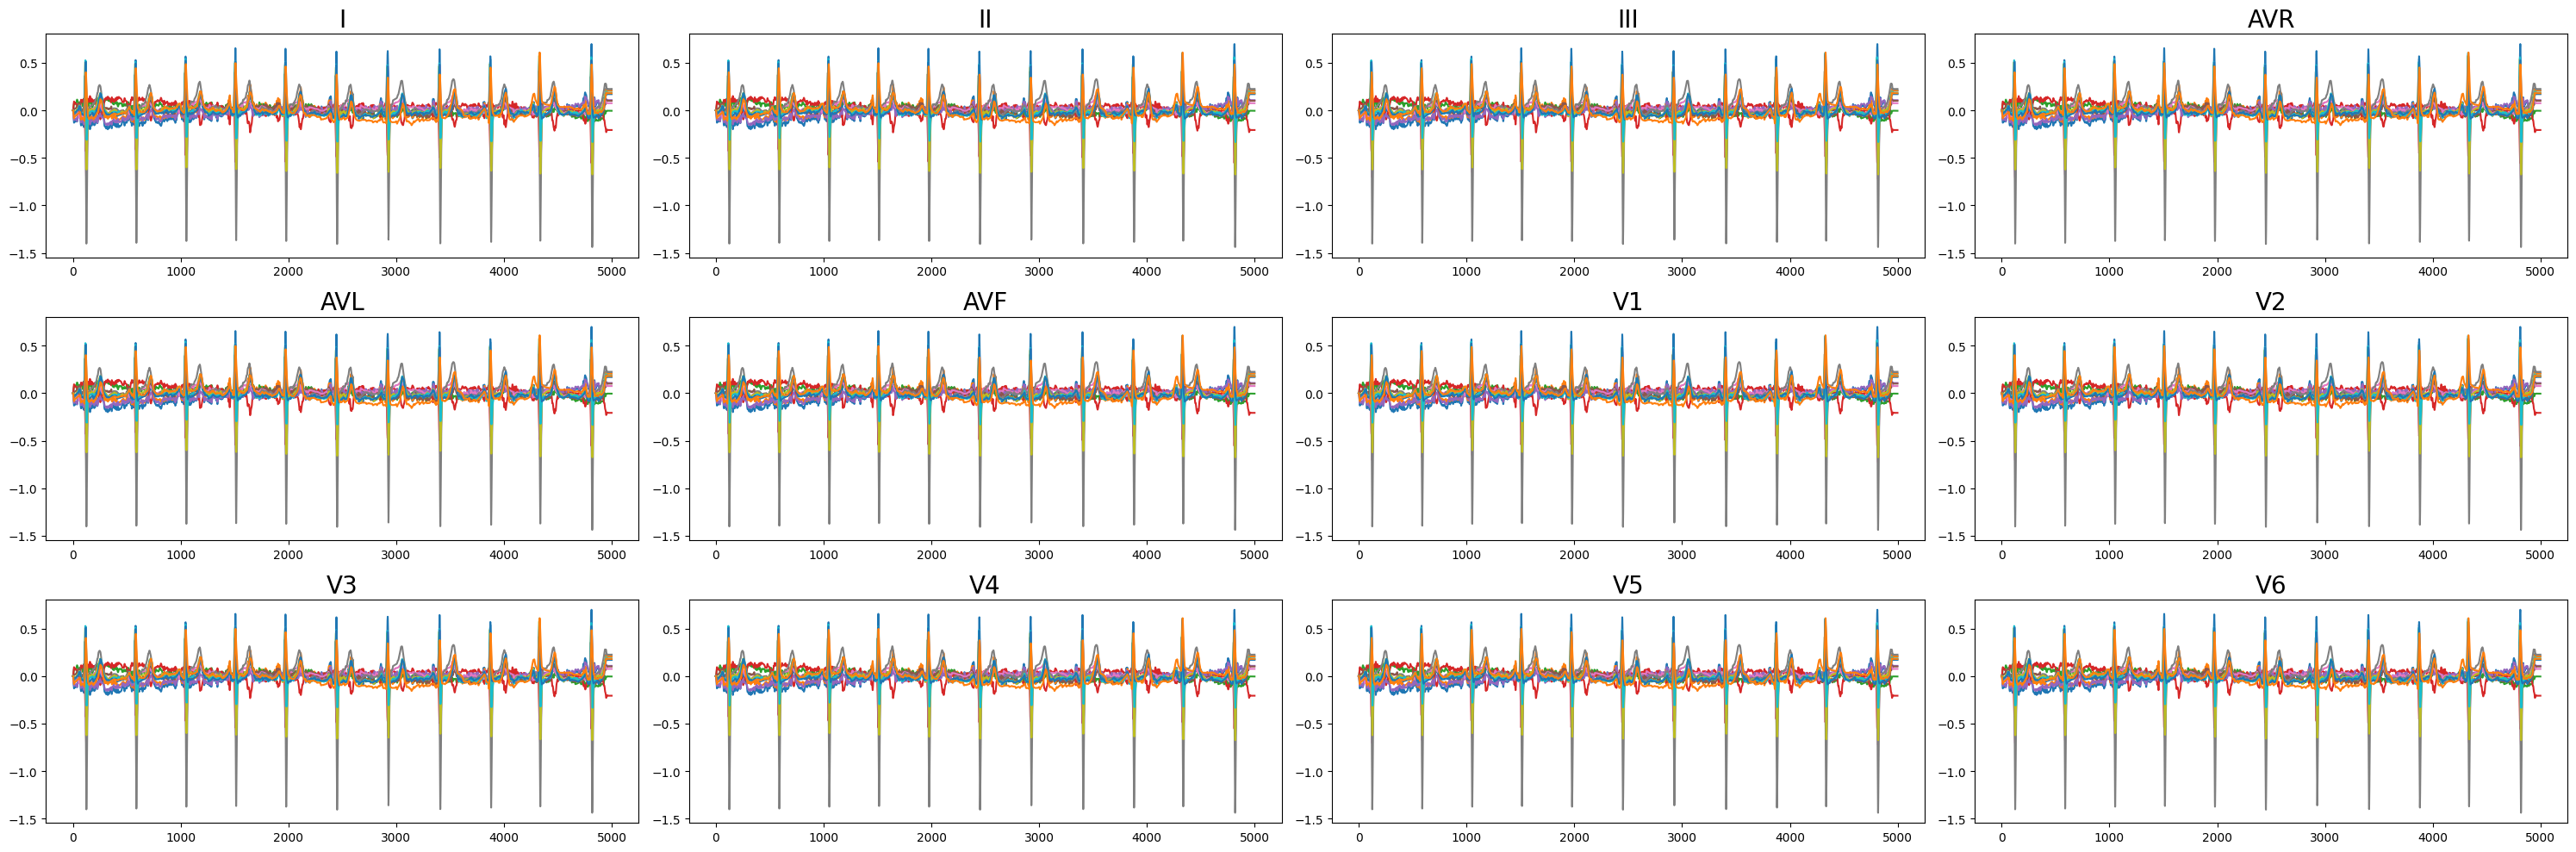

In [24]:
p_signal = test_signal[0].transpose(1,0).detach().numpy()
fig = plt.figure(figsize=(30,10))
leadNames = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
print(y_test[0])
for i,lead in enumerate(leadNames):
    ax1 = fig.add_subplot(3,4,i+1)
    ax1.set_title(leadNames[i], fontsize=20)
    ax1.plot(p_signal)
fig.tight_layout()

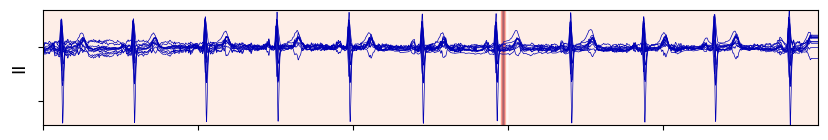

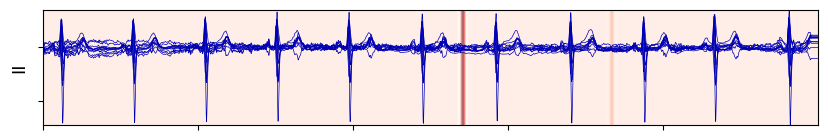

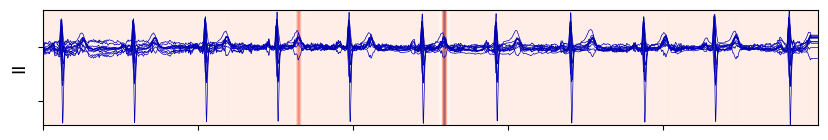

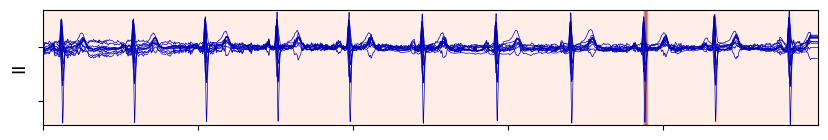

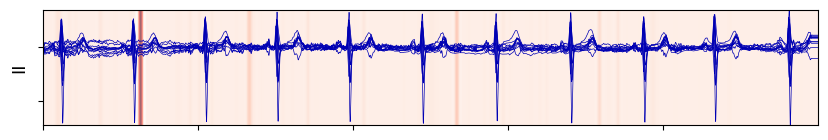

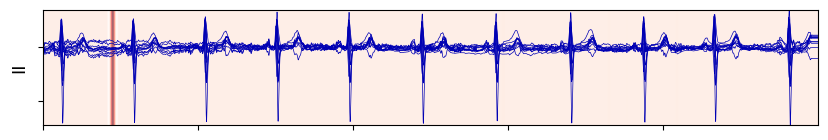

In [25]:
def plot_ax(ax, signal, sampling_rate, plot_grid=True):
    color_line = (0, 0, 0.7)
    color_major = (1, 0, 0)
    color_minor = (1, 0.7, 0.7)

    ax.plot(np.arange(0, len(signal)), signal, linewidth=0.5, color=color_line)

    if plot_grid:
        # set major grid
        xmajor = np.arange(0, len(signal), sampling_rate * 0.2)
        ymajor = np.arange(signal.min(), signal.max(), 0.5)
        ax.set_xticks(xmajor, minor=False)
        ax.set_xticks(xmajor, minor=False)
        ax.set_yticks(ymajor, minor=False)
        ax.grid(which="major", color=color_major, linewidth=0.5)

        # set minor grid
        xminor = np.arange(0, len(signal), sampling_rate * 0.04)
        yminor = np.arange(signal.min(), signal.max(), 0.1)
        ax.set_xticks(xminor, minor=True)
        ax.set_yticks(yminor, minor=True)
        ax.grid(which="minor", color=color_minor, linewidth=0.5)

    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])

    ax.margins(0)

    ax.set_ylim(signal.min(), signal.max())
    
def plot_12(ecg, sampling_rate, plot_grid=True):
    "This function is ridiculously slow and there are mutch better ways to implemt"
    figsize = (25, 1.5 * 10)

    height_ratios = [ecg[:, i].max() - ecg[:, i].min() for i in range(12)]
    height_ratios = [i / height_ratios[0] for i in height_ratios]
    fig, axs = plt.subplots(12, 1, figsize=figsize, gridspec_kw={"height_ratios": height_ratios})
    fig.subplots_adjust(hspace=0.0)
    for i, ax in enumerate(axs):
        plot_ax(ax, ecg[:, i], sampling_rate, plot_grid=plot_grid)
        ax.set_ylabel(lead_index[i], fontsize=13)

    return fig, axs

#python plot_attention.py sadd/JS05865 vit_best/ 6
lead_index = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
lead = 1
for head in range(6):
    fig, ax = plt.subplots(figsize=(10, 1.5))
    plot_ax(ax, signal=p_signal, plot_grid=False, sampling_rate=500)
    ax.pcolorfast(ax.get_xlim(), ax.get_ylim(), attn[:, head][np.newaxis], cmap="Reds", alpha=0.6)
    ax.set_ylabel(lead_index[lead], fontsize=13)
